# Unsupervised Bayesian Anomaly Detection Using Beta Binomial Distribution

This notebook goes through an example of how one could use a bayesian framework to do unsupervised anomaly detection. In this particular example, we will consider medical coding behaviors from doctor office visits for evaluation and management services.

**Note that all data and results in this notebook are synthetic!** To see the data generation process, please see `/data/generate_data.ipynb`.

What is an E/M code?
1. E/M coding is the process by which physician-patient encounters are translated into five digit CPT codes to facilitate billing.
2. There are many attributes of the encounter that factor into the level of coding
    1. History
    2. Examination
    3. Medical decision making
    4. Counseling
    5. Coordination of care
    6. Nature of presenting problem
    7. Time (spent with patient)
    
The first three (history, examination, medical decision making) are considered the key components that determine the level of an E/M code.

# Setup

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa
from random import randint
import statsmodels.formula.api as sm

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
matplotlib.rcParams['figure.figsize'] = (10, 6)

sys.path.append('../../../')
import analysis as an
import em_codes as em

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Create DB Engine
db_url = 'postgres://localhost:5432/VincentLa'
db_engine = sa.create_engine(db_url)
conn = db_engine.connect()
conn.execute('CREATE SCHEMA IF NOT EXISTS tutorial_data_ingest;')
metadata = sa.MetaData(bind=conn)

In [3]:
# Define EM code groups
OFFICE_EST_PATIENT = [1, 2, 3, 4, 5]

Read in data! Data generation process is [here](https://github.com/CloverHealth/pycon2017/blob/master/bayesian_analysis/data/generate_data.ipynb)

In [4]:
claim_lines = sa.Table(
    'claim_lines',
    metadata,
    schema='tutorial_data_ingest',
    autoload=True
)

Read in the data frame so we can explore!

In [5]:
claims = pd.read_sql(em.get_claims_base_data(claim_lines, OFFICE_EST_PATIENT), conn)

Run the analysis, we will look at the output of this later in the notebook!

In [6]:
result_output, distribution_values_output = an.run(conn, claim_lines, OFFICE_EST_PATIENT)
results = result_output['All']

# Exploration

Let's explore the data intuitively!

In [29]:
summary = {
    'claims': [claims.shape[0]],
    'providers': [claims.servicing_provider_npi.nunique()],
    'procedures': [claims.procedure_code.nunique()],
}
summary = pd.DataFrame(summary, index=['Number of Unique Observations'])
summary

,claims,procedures,providers
Number of Unique Observations,152672,5,1498


In [7]:
claims.head()

,personid,servicing_provider_npi,procedure_code,procedure_name,procedure_name_array
0,6720,Dr. Carey Harris,3,"Evaluation and Management, Medium Intensity","[Evaluation and Management, Medium Intensity]"
1,12953,Dr. Carey Harris,1,"Evaluation and Management, Lowest Intensity","[Evaluation and Management, Lowest Intensity]"
2,5408,Dr. Carey Harris,1,"Evaluation and Management, Lowest Intensity","[Evaluation and Management, Lowest Intensity]"
3,7556,Dr. Carey Harris,1,"Evaluation and Management, Lowest Intensity","[Evaluation and Management, Lowest Intensity]"
4,23107,Dr. Carey Harris,5,"Evaluation and Management, Highest Intensity","[Evaluation and Management, Highest Intensity]"


We've generated only 5 different types of procedure codes in this data set. In reality, there are many types of E/M codes. In this case, we only focus on one type.

In [35]:
claims[['procedure_code', 'procedure_name']].drop_duplicates().reset_index(drop=True).sort_values('procedure_code')

,procedure_code,procedure_name
1,1,"Evaluation and Management, Lowest Intensity"
4,2,"Evaluation and Management, Second Lowest Inten..."
0,3,"Evaluation and Management, Medium Intensity"
3,4,"Evaluation and Management, High Intensity"
2,5,"Evaluation and Management, Highest Intensity"


Most doctors bill between 50 and 150 encounters in this data set. A few providers bill as many as 200 - 250 E/M encounters.

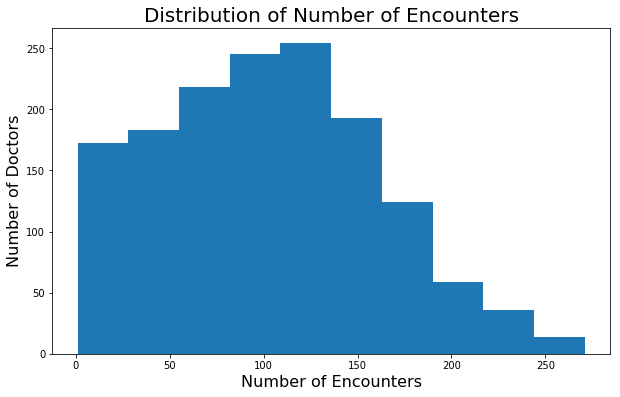

In [10]:
number_of_encounters = claims.groupby('servicing_provider_npi').size()
plt.hist(number_of_encounters)
plt.ylabel('Number of Doctors', fontsize=16)
plt.xlabel('Number of Encounters', fontsize=16)
plt.title('Distribution of Number of Encounters', fontsize=20)
plt.show()

Let's now look at the overall distribution of intensities. We see that in the aggregate, the most common codes are levels 3 and 4. There are very few level 1's. A bit more level 2's, and slightly more level 5's. However, notice that the number of encounters billed as level 5's are much lower than level 3's and 4's.

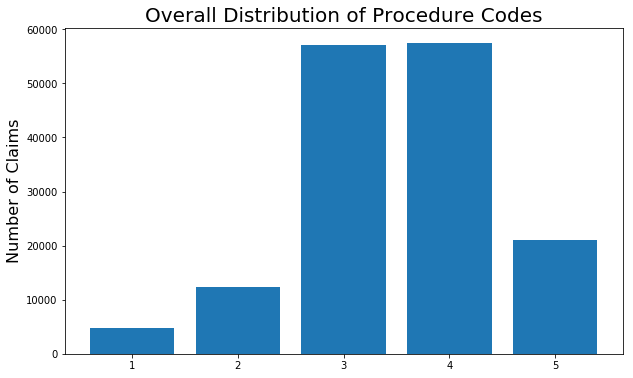

In [11]:
codes = claims.groupby('procedure_code').size().index
number_of_encounters = claims.groupby('procedure_code').size()
plt.bar(codes, number_of_encounters, align='center')
plt.xticks(codes, codes)
plt.ylabel('Number of Claims', fontsize=16)
plt.title('Overall Distribution of Procedure Codes', fontsize=20)
plt.show()

Next, we see that there are **three** distinct "clusters" of providers.

1. The majority of providers bill level 5 E/M codes very infrequently, on average about **10 percent** of the time.
2. The minority of providers bill level 5 E/M codes at a slightly higher rate, at around **25 percent** of the time.
3. The extreme outliers bill extremely high proportion of level 5 E/M codes, ranging from **50 to 80 percent** of the time.

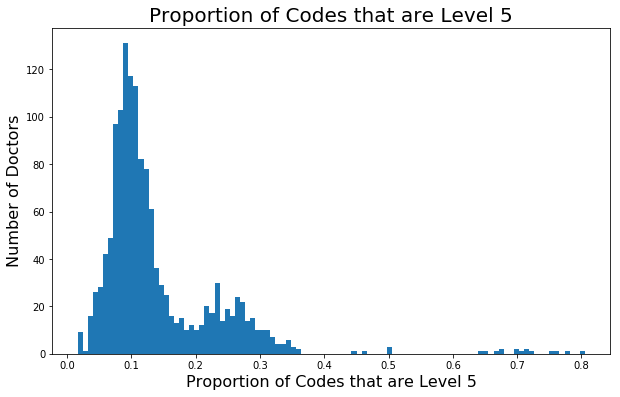

In [25]:
plt.hist(result_output['All'].pct_high_encounters, bins=100)
plt.ylabel('Number of Doctors', fontsize=16)
plt.xlabel('Proportion of Codes that are Level 5', fontsize=16)
plt.title('Proportion of Codes that are Level 5', fontsize=20)
plt.show()

# Anomaly Detection Results

### Lowest Hanging Fruit: Extreme Outliers

From the previous visualization, we saw three "clusters" of providers. As you can see below, the vast majority of the providers are in the first cluster, a relatively small amount are in the second cluster, and very few are in the third cluster of extreme outliers.

In [44]:
cluster1 = results.loc[(results.pct_high_encounters >= 0) & (results.pct_high_encounters <= 0.2)]
cluster2 = results.loc[(results.pct_high_encounters > 0.2) & (results.pct_high_encounters <= 0.4)]
cluster3 = results.loc[(results.pct_high_encounters > 0.4) & (results.pct_high_encounters <= 1)]

# Add something about cost
cluster_summary = pd.DataFrame({
    'Number of Providers': [cluster1.shape[0], cluster2.shape[0], cluster3.shape[0]],
    'Average Proportion of Level 5 Billed': [cluster1.pct_high_encounters.mean(),
                                             cluster2.pct_high_encounters.mean(),
                                             cluster3.pct_high_encounters.mean()],
}, index=['Cluster 1: Normal Coders', 'Cluster 2: Potential Upcoders', 'Cluster 3: Extreme Outliers'])
cluster_summary

,Average Proportion of Level 5 Billed,Number of Providers
Cluster 1: Normal Coders,0.101704,1115
Cluster 2: Potential Upcoders,0.262754,263
Cluster 3: Extreme Outliers,0.653354,20


As the lowest hanging fruit, I would first work with the third cluster of "extreme outliers". These providers seem to be billing at a much higher rate compared to others and are immediately suspicious irregardless of external possible explanations such as patient demographics, population risk, etc.

In addition, the number of providers here are relatively few, but make up ____ dollars of total cost. This would be the lowest hanging fruit to work with subject matter experts to review medical charts in more detail and investigate more.

In [60]:
cluster3.sort_values(by=['pct_high_encounters'], ascending=False).head(15)

,observations,successes,pct_high_encounters,naive_perc,group,a,b,regressed_prob,prob_above_average
servicing_provider_npi,,,,,,,,,
Dr. Ethel Dupre,77.0,62.0,0.805195,0.805195,All,64.466156,29.755939,0.684194,1.00000
Dr. Joseph Osborne,9.0,7.0,0.777778,0.777778,All,9.466156,16.755939,0.360999,0.95575
Dr. Martin Carroll,124.0,94.0,0.758065,0.758065,All,96.466156,44.755939,0.683081,1.00000
Dr. Mary Cauthen,130.0,98.0,0.753846,0.753846,All,100.466156,46.755939,0.682412,1.00000
Dr. Sean Yamakawa,121.0,87.0,0.719008,0.719008,All,89.466156,48.755939,0.647264,0.99996
Dr. Damon Means,39.0,28.0,0.717949,0.717949,All,30.466156,25.755939,0.541889,0.99927
Dr. Grace Chambers,74.0,53.0,0.716216,0.716216,All,55.466156,35.755939,0.608034,0.99995
Dr. Karen Banks,100.0,71.0,0.710000,0.710000,All,73.466156,43.755939,0.626726,0.99998
Dr. Nicole Kelley,115.0,80.0,0.695652,0.695652,All,82.466156,49.755939,0.623694,0.99998


### Digging Deeper: Identifying Outliers Beyond the Extremes

# Visualization

Let's make some visualizations!

In this section, we will actually visualize the distribution of the posterior, p, that we are estimating. That is, we will visualize the distribution of our posterior opinion of the proportion of level 5 codes a provider will bill.

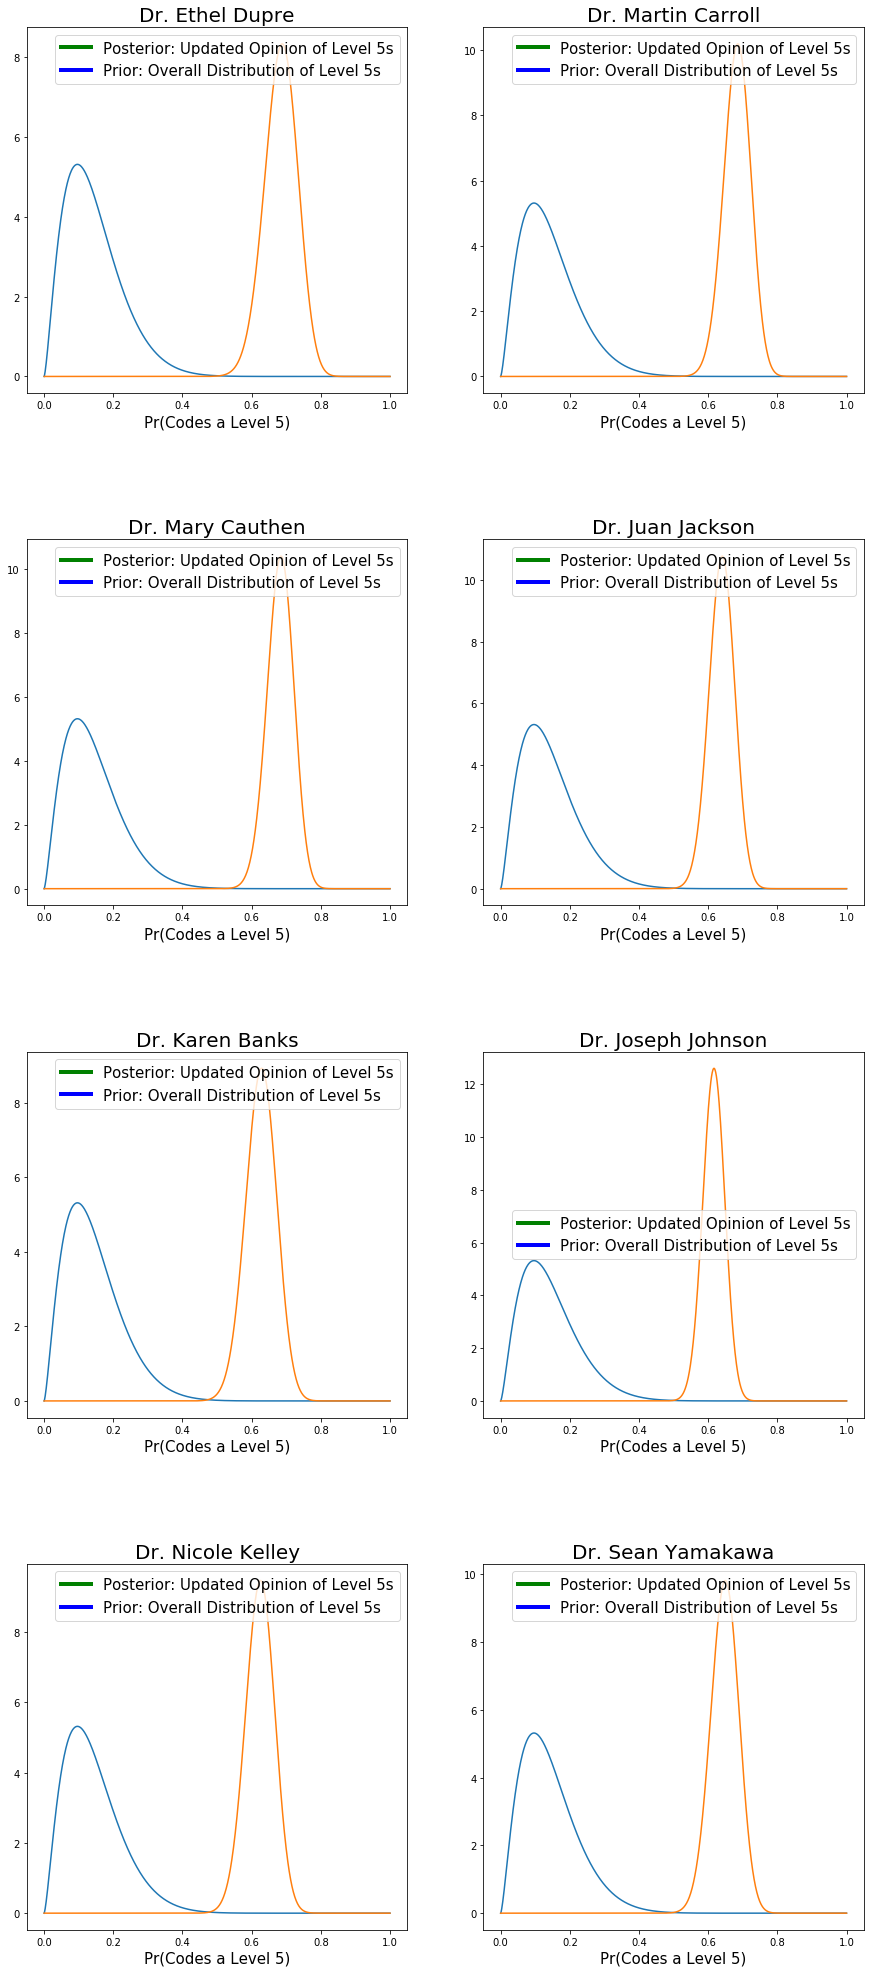

In [16]:
fig = plt.figure(figsize=(15, 35))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(hspace=.4)
ax_list = [fig.add_subplot(ss) for ss in gs1]

distribution_values = distribution_values_output['All']

npis = result_output['All'].sort_values(['prob_above_average'], ascending=False).head(8).index
for i,npi in enumerate(npis):
    ax=ax_list[i]
    ax.plot(distribution_values['prior'][0], distribution_values['prior'][1])
    ax.plot(distribution_values[npi][0], distribution_values[npi][1])
    ax.set_title(npi, fontsize=20)
    ax.set_xlabel('Pr(Codes a Level 5)', fontsize=15)
    posterior = mlines.Line2D([], [], color='green', label='Posterior: Updated Opinion of Level 5s', linewidth=4)
    prior = mlines.Line2D([], [], color='blue', label='Prior: Overall Distribution of Level 5s', linewidth=4)

    ax.legend(handles=[posterior, prior], fontsize=15)

# Validating Results

How do we validate the results of our analysis? For example, one question we might have is how do we know whether the results of our analysis are due to just spurious noise, or if there's real signal here?

In this section, we talk about one very intuitive approach to validate our results. As this is unsupervised learning, it is not possible to do a traditional 'cross-validation' approach. However, one can do something similar in spirit. Below, we split out data set in half randomly by taking separating all even `personid` from odd `personid`. We then run our analysis over each of the data sets separately and return the ranking of providers in each. We then correlate the rankings obtained in the separate data sets. If rankings are highly correlated, that's decent evidence that there is real signal. If the rankings are not correlated, one might conclude that results are really due to statistical noise.

In [17]:
columns = [
    claim_lines.c.personid,
    claim_lines.c.servicing_provider_npi,
    claim_lines.c.procedure_code,
    claim_lines.c.procedure_name
]
claim_lines_1 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 1)
).correlate(None).alias('claim_lines_1')

claim_lines_2 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 0)
).correlate(None).alias('claim_lines_1')

In [18]:
result_output_1, distribution_values_output_1 = an.run(conn, claim_lines_1, OFFICE_EST_PATIENT)
result_output_2, distribution_values_output_2 = an.run(conn, claim_lines_2, OFFICE_EST_PATIENT)

In [19]:
output1 = result_output_1['All']
output2 = result_output_2['All']

In [20]:
combined = output1.merge(output2, left_index=True, right_index=True)

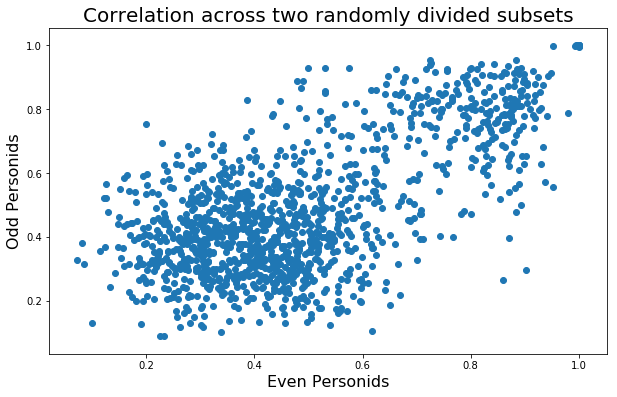

In [21]:
plt.scatter(combined.prob_above_average_x, combined.prob_above_average_y)
plt.ylabel('Odd Personids', fontsize=16)
plt.xlabel('Even Personids', fontsize=16)
plt.title('Correlation across two randomly divided subsets', fontsize=20)
plt.show()

We plot the probability above average returned for each doctor across the two randomly divided subsets (using even/odd personids). There are two main clusters (which is mostly the result of the data generation process) that make it pretty apparent to see the pattern. In the data generation process there are only 2 types of providers, upcoders and non-upcoders. The cluster in the bottom left are the non-upcoders. Notice how the probability above average in one of the randomly divided subsets for each provider is basically uncorrelated with their score in the other data set.

However, notice that for the data points in the top right cluster, which represent the upcoders, the correlation is a lot tighter and much less spread. This provides some evidence that these providers actually are associated with more level 5 codes as opposed to the pattern being generated by random noise.

## Steps for Case Study

1. Generate Fake Data. This includes personid, servicing_provider_npi, procedure_code, cost, and provider_specialty
2. Basic visualizations
    1. Distribution of number of encounters
    2. Overall distribution of procedure codes
    3. Proportion of codes that are level 5: 3 clusters. This is the most important of the intro visualizations
3. Results
    1. The outliers (3rd cluster) are the lowest hanging fruit. They just look suspicious with level 5 coding rates around 0.7. Show a visualization of maybe just a simple 2x2 table. The first column is percentage of total doctors. The second column is percentage of total cost.
    2. Now for the first two clusters, we could just look at the highest providers, but differences between specialties.
    3. Produce a density plot grouped by provider specialty. Ideally it would show primary care providers are least likely to code level 5. cardiologists and others are more likely to code a level 5.
    4. Beta Binomial very brief description and visualizations
    5. Next steps: tool that can search a provider and provide visualization?
4. Conclusions
    1. What to do next?
    2. Reviewing charts.
    3. Building visualization tools
    4. R Shiny app?